In [1]:
from math import exp
import neo
from quantities import ms
from pyNN.utility import get_simulator, init_logging, normalized_filename
from pyNN.utility.plotting import DataTable
from importlib import import_module

import matplotlib.pyplot as plt
import numpy as np
from data_handler import *

import time

TIMER_GLOBAL_START = time.time()

op_debug = False
op_dendritic_delay_fraction = False
op_fit_curve = False
op_plot_figure = True # False #
op_timer = True
op_simulator = "neuron" #'brian' # 

sim_timestep = 0.1      # (ms) timestep for simulator
firing_period = 10    # (ms) interval between spikes
sample_period = 50 # (ms) for each img sample
batch_size = 50

n_neurons = 784         # number of input layer synapses (MNIST image dimension)
n_out = 10              # number of output layer synapses 
sample_num = 0 # to be updated after loading data
batch_time = batch_size * sample_period # each simulate  simulation duration
batch_num = 0 # to be updated after loading data
spike_thresh = 0.3 # when image pixel value greater than spike_thresh
delay = sim_timestep * 2              # (ms) synaptic time delay, default=3.0
min_delay = sim_timestep
max_delay = sim_timestep * 5
cell_parameters = {
    "tau_m": firing_period, #10.0,       # (ms)
    "v_thresh": -50.0,   # (mV)
    "v_reset": -60.0,    # (mV)
    "v_rest": -60.0,     # (mV)
    "cm": 1.0,           # (nF)
    "tau_refrac": firing_period / 5, #firing_period / 2,  # (ms) long refractory period to prevent bursting
}

sim = import_module("pyNN."+op_simulator)

if op_debug: 
    init_logging(None, debug=True)

sim.setup(sim_timestep=sim_timestep, min_delay="auto")

0

In [2]:
# Load MNIST data
print "loading MNIST data..."
TIMER_START = time.time()
dh = DataHandler(randseed=19023895)
dh.load_data()
dh.shuffle_data()
sample_num = dh.get_sample_size('test')
batch_num = int(sample_num/batch_size)
TIMER_END = time.time()
print "loaded!"
print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)
# generate spike table
print "generating spike table..."
TIMER_START = time.time()
in_spikes, out_spikes = dh.generate_spikes(data_type='test',
                                            sample_period=sample_period,
                                            firing_period=firing_period,
                                            thresh=spike_thresh)

#in_spikes, out_spikes = dh.get_batch_spikes(data_type='test', i_batch, batch_size, sample_period)
in_spike_sequence_generator = build_spike_sequences(in_spikes)
out_spike_sequence_generator = build_spike_sequences(out_spikes)
TIMER_END = time.time()
print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)

loading MNIST data...
data loading from pickle...
loaded!
	 - Time Usage: 8.06515
generating spike table...
n_samples =  10000
n_neurons =  784
t_stop =  500000
sample_period =  50
firing_period =  10
generate random poisson spikes...
generate poisson spike till 25000.5 in 500000.0 : 5.000 %
generate poisson spike till 50002.3 in 500000.0 : 10.000 %
generate poisson spike till 75009.7 in 500000.0 : 15.002 %
generate poisson spike till 100006.8 in 500000.0 : 20.001 %
generate poisson spike till 125006.1 in 500000.0 : 25.001 %
generate poisson spike till 150002.8 in 500000.0 : 30.001 %
generate poisson spike till 175008.1 in 500000.0 : 35.002 %
generate poisson spike till 200003.6 in 500000.0 : 40.001 %
generate poisson spike till 225047.1 in 500000.0 : 45.009 %
generate poisson spike till 250007.5 in 500000.0 : 50.001 %
generate poisson spike till 275009.5 in 500000.0 : 55.002 %
generate poisson spike till 300007.6 in 500000.0 : 60.002 %
generate poisson spike till 325001.1 in 500000.0 

In [3]:
# === Build up Neural Network ==========================================
print "buildup neural network..."
TIMER_START = time.time()
p_in_drive = sim.Population(n_neurons, sim.SpikeSourceArray(spike_times=in_spike_sequence_generator),
                    label="in_drive")
p_in = sim.Population(n_neurons, sim.IF_cond_exp(**cell_parameters),
                    initial_values={"v": cell_parameters["v_reset"]}, label="in")
p_out = sim.Population(n_out, sim.IF_cond_exp(**cell_parameters),
                    initial_values={"v": cell_parameters["v_reset"]}, label="out")

p_out_drive = sim.Population(n_out, sim.SpikeSourceArray(spike_times=out_spike_sequence_generator),
                    label="out_drive")
'''
stdp_model = sim.STDPMechanism(
                timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                                    A_plus=0.01, A_minus=0.012),
                weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=0.0000001),
                weight=  0.00000005, # 0.05, #
                delay=delay,
                dendritic_delay_fraction=float(op_dendritic_delay_fraction))
'''
stdp_model = sim.STDPMechanism(
                timing_dependence=sim.SpikePairRule(tau_plus=sample_period, tau_minus=sample_period,
                                                    A_plus=0.01, A_minus=0.012),
                weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=0.0000001),
                weight=  0.00000005, # 0.05, #
                delay=delay,
                dendritic_delay_fraction=float(op_dendritic_delay_fraction))


# Define Connections
inject_syn_weight = 1.00 # modified!!!
connections_in_drive = sim.Projection(p_in_drive, p_in, sim.OneToOneConnector(), 
                               sim.StaticSynapse(weight=inject_syn_weight, delay=delay))

connections_mid = sim.Projection(p_in, p_out, sim.AllToAllConnector(), stdp_model)

connections_out_drive = sim.Projection(p_out_drive, p_out, sim.OneToOneConnector(), 
                               sim.StaticSynapse(weight=inject_syn_weight, delay=delay))

TIMER_END = time.time()

print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)

p_in_drive.record('spikes')
p_in.record( ['spikes'])
p_out.record(['spikes','v'])
p_out_drive.record('spikes')

weight_recorder = WeightRecorder(sampling_interval=1.0, projection=connections_mid)

buildup neural network...
	 - Time Usage: 0.71484


In [4]:
# === Start simulating! ===============================================batch_time==========
def report_time(t):
    # Do Nothing
    return t + batch_time
6
print("start simulating! ...")
print("\tTotal simulation time: %d"%(sample_period * sample_num))
AVG_BATCH_TIME_USAGE = 0
i_batch = 0

start simulating! ...
	Total simulation time: 500000


In [5]:
print(batch_time)
print(i_batch)

2500
0


In [6]:
batch_num = 3 # Used for debugging, run subset of the whole
for i in range(batch_num):
    TIMER_START = time.time()
    sim.run(batch_time, callbacks = [report_time, weight_recorder])
    TIMER_END = time.time()
    AVG_BATCH_TIME_USAGE = (AVG_BATCH_TIME_USAGE*i_batch/(i_batch+1)+(TIMER_END-TIMER_START)/(i_batch+1))
    EXPECT_TIME_LEFT = AVG_BATCH_TIME_USAGE * (batch_num-i_batch-1)
    print("\t Batch - %d in %d - \t%.2f" % (i_batch, batch_num, i_batch*1.0/batch_num*100) + "%")
    print("\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)+",\t remain time - %.5f"%EXPECT_TIME_LEFT)

    i_batch += 1
    sim.end()

	 Batch - 0 in 3 - 	0.00%
	 - Time Usage: 46.58450,	 remain time - 93.16900
	 Batch - 1 in 3 - 	33.33%
	 - Time Usage: 45.90248,	 remain time - 46.24349
	 Batch - 2 in 3 - 	66.67%
	 - Time Usage: 46.68858,	 remain time - 0.00000


In [7]:
# === Collect data ==============================================================
p_in_drive_data = p_in_drive.get_data().segments[0]
p_in_data = p_in.get_data().segments[0]
p_out_data = p_out.get_data().segments[0]
p_out_drive_data = p_out_drive.get_data().segments[0]

weights = weight_recorder.get_weights()
final_weights = np.array(weights[-1])

print "DONE"

DONE


plotting  Figure/20181206/my_stdp_00000_neuron_20181206-165529.png
	 - Time Usage: 62.58299
plotting  Figure/20181206/my_stdp_00002_neuron_20181206-165631.png
	 - Time Usage: 61.85392
Simulation Ends! - Total Time Usage: 295.67709
inject_syn_weight = 1.000000


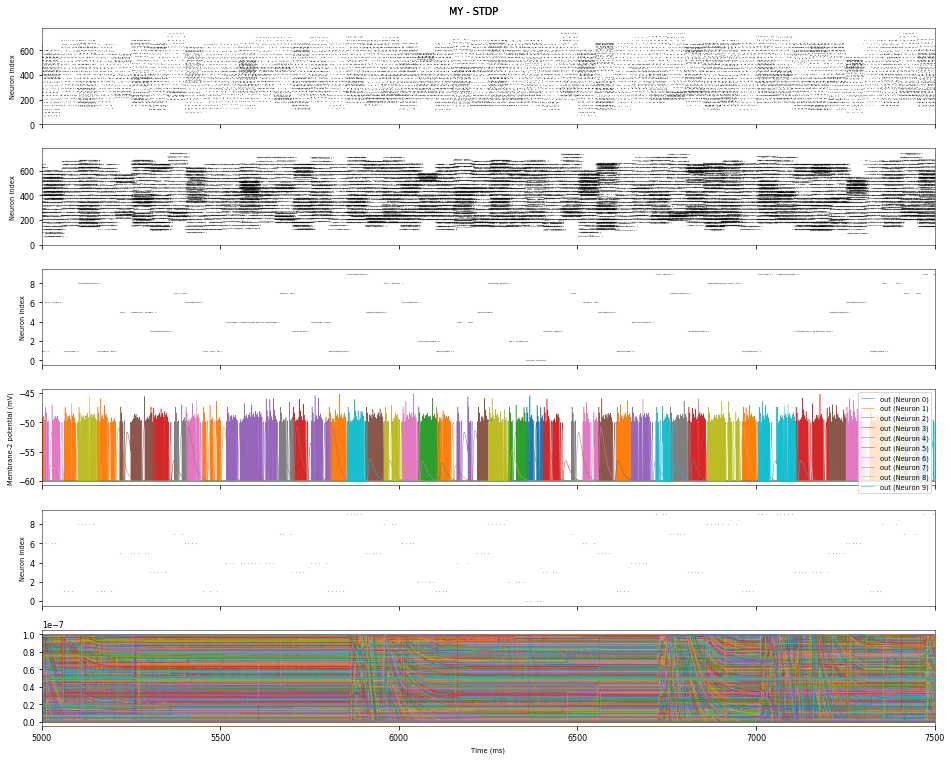

In [8]:
# === Plotting ==================================================================
#plotNeuronsSpikes(test_img_spike_table)
# random plotting
#i_batch =  0 # np.random.randint(batch_num)
#print "i_batch = %d"%i_batch
for i_batch in [0,2]: # if op_plot_figure:
    TIMER_START = time.time()
    from pyNN.utility.plotting import Figure, Panel, DataTable
    figure_filename = normalized_filename("Figure", "my_stdp_%05d"%i_batch, "png", op_simulator)
    print "plotting ", figure_filename
    Figure(
        # p_in_drive spikes
        Panel(p_in_drive_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(batch_time*i_batch, batch_time*(i_batch+1))),
        # p_in spikes
        Panel(p_in_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(batch_time*i_batch, batch_time*(i_batch+1))),
        # p_out spikes
        Panel(p_out_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(batch_time*i_batch, batch_time*(i_batch+1))),
        Panel(p_out_data.filter(name='v')[0],
              ylabel="Membrane-2 potential (mV)",
              data_labels=[p_out.label], yticks=True, xlim=(batch_time*i_batch, batch_time*(i_batch+1))),
        # p_out_drive spikes
        Panel(p_out_drive_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(batch_time*i_batch, batch_time*(i_batch+1))),
        # weights
        Panel(weights, xticks=True, yticks=True, xlabel="Time (ms)",
              legend=False, xlim=(batch_time*i_batch, batch_time*(i_batch+1))),
        title="MY - STDP",
        #annotations="Simulated with %s" % op_simulator.upper(),
        size = (16,12)
    ).save(figure_filename)
    TIMER_END = time.time()
    print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)

TIMER_GLOBAL_END = time.time()
print "Simulation Ends! - Total Time Usage: %.5f"%(TIMER_GLOBAL_END-TIMER_GLOBAL_START)
print "inject_syn_weight = %f"% inject_syn_weight

# Test

In [1]:
from math import exp
import neo
from quantities import ms
from pyNN.utility import get_simulator, init_logging, normalized_filename
from pyNN.utility.plotting import DataTable
from importlib import import_module

import matplotlib.pyplot as plt
import numpy as np
from data_handler import *

import time

TIMER_GLOBAL_START = time.time()

op_simulator = "neuron"
op_debug = False
op_dendritic_delay_fraction = False
op_fit_curve = False
op_plot_figure = True # False #
op_timer = True

sim_timestep = 0.5      # (ms) timestep for simulator
firing_period = 10.0    # (ms) interval between spikes
n_neurons = 784         # number of input layer synapses (MNIST image dimension)
n_out = 10              # number of output layer synapses 
batch_size = 10
sample_period = 40 # (ms) for each img sample
sample_num = 0 # to be updated after loading data
batch_time = batch_size * sample_period # each simulate  simulation duration
batch_num = 0 # to be updated after loading data
spike_thresh = 0.3 # when image pixel value greater than spike_thresh
delay = sim_timestep * 2              # (ms) synaptic time delay, default=3.0
min_delay = sim_timestep
max_delay = sim_timestep * 5
cell_parameters = {
    "tau_m": 10.0,       # (ms)
    "v_thresh": -50.0,   # (mV)
    "v_reset": -60.0,    # (mV)
    "v_rest": -60.0,     # (mV)
    "cm": 1.0,           # (nF)
    "tau_refrac": firing_period / 2,  # (ms) long refractory period to prevent bursting
}

#sim = import_module("pyNN."+op_simulator)

if op_debug: 
    init_logging(None, debug=True)

#sim.setup(sim_timestep=0.3, min_delay="auto")
#sim.setup(sim_timestep=0.3, min_delay="auto", max_delay=max_delay)

In [2]:
# Load MNIST data
print "loading MNIST data..."
TIMER_START = time.time()
dh = DataHandler(randseed=19023895)
dh.load_data()
dh.shuffle_data()
sample_num = dh.get_sample_size('test')
batch_num = int(sample_num/batch_size)
TIMER_END = time.time()
print "loaded!"
print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)
# generate spike table
print "generating spike table..."
TIMER_START = time.time()
in_spikes, out_spikes = dh.generate_spikes(data_type='test',
                                            sample_period=sample_period,
                                            firing_period=firing_period,
                                            thresh=spike_thresh)

#in_spikes, out_spikes = dh.get_batch_spikes(data_type='test', i_batch, batch_size, sample_period)
in_spike_sequence_generator = build_spike_sequences(in_spikes)
out_spike_sequence_generator = build_spike_sequences(out_spikes)
TIMER_END = time.time()
print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)

loading MNIST data...
data loading from pickle...
loaded!
	 - Time Usage: 8.07714
generating spike table...
n_samples =  10000
n_neurons =  784
t_stop =  400000
generate random poisson spikes...
generate poisson spike till 20018.5 in 400000.0 : 5.005 %
generate poisson spike till 40005.9 in 400000.0 : 10.001 %
generate poisson spike till 60001.1 in 400000.0 : 15.000 %
generate poisson spike till 80006.3 in 400000.0 : 20.002 %
generate poisson spike till 100006.8 in 400000.0 : 25.002 %
generate poisson spike till 120004.6 in 400000.0 : 30.001 %
generate poisson spike till 140012.1 in 400000.0 : 35.003 %
generate poisson spike till 160002.3 in 400000.0 : 40.001 %
generate poisson spike till 180006.0 in 400000.0 : 45.002 %
generate poisson spike till 200003.6 in 400000.0 : 50.001 %
generate poisson spike till 220004.5 in 400000.0 : 55.001 %
generate poisson spike till 240004.6 in 400000.0 : 60.001 %
generate poisson spike till 260011.2 in 400000.0 : 65.003 %
generate poisson spike till 28

In [3]:
# === Start simulating! ======================================================
def report_time(t):
    # Do Nothing
    return t + batch_time
6
print("start simulating! ...")
print("\tTotal simulation time: %d"%(sample_period * sample_num))
AVG_BATCH_TIME_USAGE = 0
i_batch = 0
flag_init = True

start simulating! ...
	Total simulation time: 400000


In [11]:
# === in loop =================================================================
print(i_batch)
in_spikes, out_spikes = dh.get_batch_spikes(data_type='test', i_batch=i_batch, 
                                            batch_size=batch_size, sample_period=sample_period)
in_spike_sequence_generator = build_spike_sequences(in_spikes)
out_spike_sequence_generator = build_spike_sequences(out_spikes)

1


In [12]:
TIMER_START = time.time()
sim = import_module("pyNN."+op_simulator)
sim.setup(sim_timestep=0.3, min_delay="auto")

p_in_drive = sim.Population(n_neurons, sim.SpikeSourceArray(spike_times=in_spike_sequence_generator),
                    label="in_drive")
p_in = sim.Population(n_neurons, sim.IF_cond_exp(**cell_parameters),
                    initial_values={"v": cell_parameters["v_reset"]}, label="in")
p_out = sim.Population(n_out, sim.IF_cond_exp(**cell_parameters),
                    initial_values={"v": cell_parameters["v_reset"]}, label="out")

p_out_drive = sim.Population(n_out, sim.SpikeSourceArray(spike_times=out_spike_sequence_generator),
                    label="out_drive")

stdp_model = sim.STDPMechanism(
                timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                                    A_plus=0.01, A_minus=0.012),
                weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=0.0000001),
                weight=  0.00000005, # 0.05, #
                delay=delay,
                dendritic_delay_fraction=float(op_dendritic_delay_fraction))

# Define Connections
connections_in_drive = sim.Projection(p_in_drive, p_in, sim.OneToOneConnector(), 
                               sim.StaticSynapse(weight=10.0, delay=delay))

connections_mid = sim.Projection(p_in, p_out, sim.AllToAllConnector(), stdp_model)

connections_out_drive = sim.Projection(p_out_drive, p_out, sim.OneToOneConnector(), 
                               sim.StaticSynapse(weight=10.0, delay=delay))
if not flag_init:
    connections_mid.set(weight=final_weights)

p_in_drive.record('spikes')
p_in.record( ['spikes'])
p_out.record(['spikes'])
p_out_drive.record('spikes')
weight_recorder = WeightRecorder(sampling_interval=1.0, projection=connections_mid)

TIMER_END = time.time()

print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)

	 - Time Usage: 0.72208


In [13]:
TIMER_START = time.time()
sim.run(batch_time, callbacks = [report_time, weight_recorder])
TIMER_END = time.time()
AVG_BATCH_TIME_USAGE = (AVG_BATCH_TIME_USAGE*i_batch/(i_batch+1)+(TIMER_END-TIMER_START)/(i_batch+1))
EXPECT_TIME_LEFT = AVG_BATCH_TIME_USAGE * (batch_num-i_batch-1)
print("\t Batch - %d in %d - \t%.2f" % (i_batch, batch_num, i_batch*1.0/batch_num*100) + "%")
print("\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)+",\t remain time - %.5f"%EXPECT_TIME_LEFT)

	 Batch - 1 in 1000 - 	0.10%
	 - Time Usage: 10.81163,	 remain time - 8966.89474


In [14]:
# === Collect data ==============================================================
p_in_drive_data = p_in_drive.get_data().segments[0]
p_in_data = p_in.get_data().segments[0]
p_out_data = p_out.get_data().segments[0]
p_out_drive_data = p_out_drive.get_data().segments[0]

weights = weight_recorder.get_weights()
final_weights = np.array(weights[-1])
# === Clean up Simulator ========================================================
sim.end()

plotting  Results/20181204/my_stdp_neuron_20181204-163722.png
	 - Time Usage: 55.87005
Simulation Ends! - Total Time Usage: 167.61551


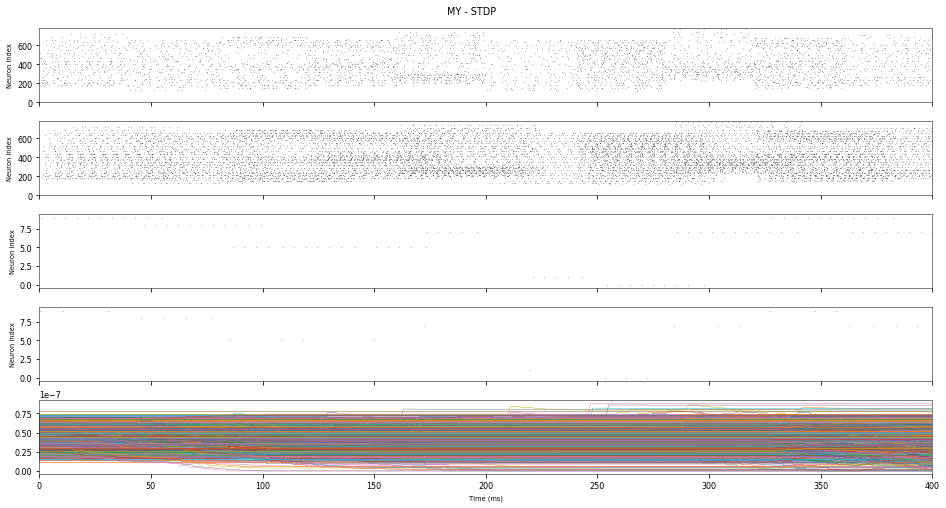

In [15]:
# === Plotting ==================================================================
#plotNeuronsSpikes(test_img_spike_table)
filename = normalized_filename("Results", "my_stdp", "pkl", op_simulator)
if op_plot_figure:
    TIMER_START = time.time()
    from pyNN.utility.plotting import Figure, Panel, DataTable
    figure_filename = filename.replace("pkl", "png")
    print "plotting ", figure_filename
    Figure(
        # p_in_drive spikes
        Panel(p_in_drive_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(0, batch_time)),
        # p_in spikes
        Panel(p_in_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(0, batch_time)),
        # p_out spikes
        Panel(p_out_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(0, batch_time)),
        # p_out_drive spikes
        Panel(p_out_drive_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(0, batch_time)),
        # weights
        Panel(weights, xticks=True, yticks=True, xlabel="Time (ms)",
              legend=False, xlim=(0, batch_time)),
        title="MY - STDP",
        #annotations="Simulated with %s" % op_simulator.upper(),
        size = (16,8)
    ).save(figure_filename)
    TIMER_END = time.time()
    print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)

TIMER_GLOBAL_END = time.time()
print "Simulation Ends! - Total Time Usage: %.5f"%(TIMER_GLOBAL_END-TIMER_GLOBAL_START)

In [16]:
flag_init = False
i_batch += 1

In [17]:
i_batch

2

In [13]:
np.shape(final_weights[final_weights>])

(7840,)

# LOOP VERSION!!!!!

In [1]:
from math import exp
import neo
from quantities import ms
from pyNN.utility import get_simulator, init_logging, normalized_filename
from pyNN.utility.plotting import DataTable
from importlib import import_module

import matplotlib.pyplot as plt
import numpy as np
from data_handler import *

import time

In [2]:
TIMER_GLOBAL_START = time.time()

In [3]:
op_simulator = 'brian' #"neuron"
op_debug = False
op_dendritic_delay_fraction = False
op_fit_curve = False
op_plot_figure = True # False #
op_timer = True

sim_timestep = 0.01      # (ms) timestep for simulator
firing_period = 0.05    # (ms) interval between spikes
n_neurons = 784         # number of input layer synapses (MNIST image dimension)
n_out = 10              # number of output layer synapses 
batch_size = 10
sample_period = 0.1 # (ms) for each img sample
sample_num = 0 # to be updated after loading data
batch_time = batch_size * sample_period # each simulate  simulation duration
batch_num = 0 # to be updated after loading data
spike_thresh = 0.3 # when image pixel value greater than spike_thresh
delay = sim_timestep * 2              # (ms) synaptic time delay, default=3.0
min_delay = sim_timestep
max_delay = sim_timestep * 5
cell_parameters = {
    "tau_m": 10.0,       # (ms)
    "v_thresh": -50.0,   # (mV)
    "v_reset": -60.0,    # (mV)
    "v_rest": -60.0,     # (mV)
    "cm": 1.0,           # (nF)
    "tau_refrac": firing_period / 2,  # (ms) long refractory period to prevent bursting
}

if op_debug: 
    init_logging(None, debug=True)

In [4]:
# Load MNIST data
print "loading MNIST data..."
TIMER_START = time.time()
dh = DataHandler(randseed=19023895)
dh.load_data()
dh.shuffle_data()
sample_num = dh.get_sample_size('test')
batch_num = int(sample_num/batch_size)
TIMER_END = time.time()
print "loaded!"
print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)
# generate spike table
print "generating spike table..."
TIMER_START = time.time()
in_spikes, out_spikes = dh.generate_spikes(data_type='test',
                                            sample_period=sample_period,
                                            firing_period=firing_period,
                                            thresh=spike_thresh)

#in_spikes, out_spikes = dh.get_batch_spikes(data_type='test', i_batch, batch_size, sample_period)
in_spike_sequence_generator = build_spike_sequences(in_spikes)
out_spike_sequence_generator = build_spike_sequences(out_spikes)
TIMER_END = time.time()
print "\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)

loading MNIST data...
data loading from pickle...
loaded!
	 - Time Usage: 8.27492
generating spike table...
n_samples =  10000
n_neurons =  784
t_stop =  1000.0
generate random poisson spikes...
generate poisson spike till 50.0 in 1000.0 : 5.003 %
generate poisson spike till 100.1 in 1000.0 : 10.009 %
generate poisson spike till 150.1 in 1000.0 : 15.012 %
generate poisson spike till 200.0 in 1000.0 : 20.003 %
generate poisson spike till 250.0 in 1000.0 : 25.001 %
generate poisson spike till 300.0 in 1000.0 : 30.001 %
generate poisson spike till 350.0 in 1000.0 : 35.004 %
generate poisson spike till 400.0 in 1000.0 : 40.003 %
generate poisson spike till 450.0 in 1000.0 : 45.004 %
generate poisson spike till 500.0 in 1000.0 : 50.003 %
generate poisson spike till 550.0 in 1000.0 : 55.004 %
generate poisson spike till 600.0 in 1000.0 : 60.002 %
generate poisson spike till 650.0 in 1000.0 : 65.003 %
generate poisson spike till 700.1 in 1000.0 : 70.006 %
generate poisson spike till 750.0 in 

In [5]:
# === Start simulating! ======================================================
def report_time(t):
    # Do Nothing
    return t + batch_time
6
print("start simulating! ...")
print("\tTotal simulation time: %d"%(sample_period * sample_num))
AVG_BATCH_TIME_USAGE = 0
i_batch = 0
flag_init = True

start simulating! ...
	Total simulation time: 1000


In [6]:
# === in loop =================================================================
while(i_batch<batch_num):
    TIMER_START = time.time()
    print("i_batch: %d in %d"% (i_batch, batch_num))
    # update spike sequence
    in_spikes, out_spikes = dh.get_batch_spikes(data_type='test', i_batch=i_batch, 
                                                batch_size=batch_size, sample_period=sample_period)
    in_spike_sequence_generator = build_spike_sequences(in_spikes)
    out_spike_sequence_generator = build_spike_sequences(out_spikes)
    
    # reset simulator
    print("\t - reseting simulator")
    sim = import_module("pyNN."+op_simulator)
    sim.setup(sim_timestep=sim_timestep, min_delay="auto")

    p_in_drive = sim.Population(n_neurons, sim.SpikeSourceArray(spike_times=in_spike_sequence_generator),
                        label="in_drive")
    p_in = sim.Population(n_neurons, sim.IF_cond_exp(**cell_parameters),
                        initial_values={"v": cell_parameters["v_reset"]}, label="in")
    p_out = sim.Population(n_out, sim.IF_cond_exp(**cell_parameters),
                        initial_values={"v": cell_parameters["v_reset"]}, label="out")

    p_out_drive = sim.Population(n_out, sim.SpikeSourceArray(spike_times=out_spike_sequence_generator),
                        label="out_drive")

    stdp_model = sim.STDPMechanism(
                    timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                                        A_plus=0.01, A_minus=0.012),
                    weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=0.0000001),
                    weight=  0.00000005, # 0.05, #
                    delay=delay,
                    dendritic_delay_fraction=float(op_dendritic_delay_fraction))

    # Define Connections
    connections_in_drive = sim.Projection(p_in_drive, p_in, sim.OneToOneConnector(), 
                                   sim.StaticSynapse(weight=10.0, delay=delay))

    connections_mid = sim.Projection(p_in, p_out, sim.AllToAllConnector(), stdp_model)

    connections_out_drive = sim.Projection(p_out_drive, p_out, sim.OneToOneConnector(), 
                                   sim.StaticSynapse(weight=10.0, delay=delay))
    if not flag_init:
        connections_mid.set(weight=final_weights)

    p_in_drive.record('spikes')
    p_in.record( ['spikes'])
    p_out.record(['spikes'])
    p_out_drive.record('spikes')
    weight_recorder = WeightRecorder(sampling_interval=1.0, projection=connections_mid)

    
    # Run simulator
    print("\t - start simulator")
    sim.run(batch_time, callbacks = [report_time, weight_recorder])
        
    # === Collect data ==============================================================
    p_in_drive_data = p_in_drive.get_data().segments[0]
    p_in_data = p_in.get_data().segments[0]
    p_out_data = p_out.get_data().segments[0]
    p_out_drive_data = p_out_drive.get_data().segments[0]

    weights = weight_recorder.get_weights()
    final_weights = np.array(weights[-1])
    # === Clean up Simulator ========================================================
    sim.end()
    print("\t - simulation ends")
    
    # if plotting
    
    # === Plotting ==================================================================
    #plotNeuronsSpikes(test_img_spike_table)
    filename = normalized_filename("Results", "my_stdp", "pkl", op_simulator)
    if op_plot_figure and i_batch%500==499 and False:
        from pyNN.utility.plotting import Figure, Panel, DataTable
        figure_filename = filename.replace("pkl", "png")
        print "\t - plotting ", figure_filename
        Figure(
            # p_in_drive spikes
            Panel(p_in_drive_data.spiketrains,
                  yticks=True, markersize=0.2, xlim=(0, batch_time)),
            # p_in spikes
            Panel(p_in_data.spiketrains,
                  yticks=True, markersize=0.2, xlim=(0, batch_time)),
            # p_out spikes
            Panel(p_out_data.spiketrains,
                  yticks=True, markersize=0.2, xlim=(0, batch_time)),
            # p_out_drive spikes
            Panel(p_out_drive_data.spiketrains,
                  yticks=True, markersize=0.2, xlim=(0, batch_time)),
            # weights
            Panel(weights, xticks=True, yticks=True, xlabel="Time (ms)",
                  legend=False, xlim=(0, batch_time)),
            title="MY - STDP",
            #annotations="Simulated with %s" % op_simulator.upper(),
            size = (16,8)
        ).save(figure_filename)
        
        
    
    # timer
    TIMER_END = time.time()
    AVG_BATCH_TIME_USAGE = (AVG_BATCH_TIME_USAGE*i_batch/(i_batch+1)+(TIMER_END-TIMER_START)/(i_batch+1))
    EXPECT_TIME_LEFT = AVG_BATCH_TIME_USAGE * (batch_num-i_batch-1)
    print("\t Batch - %d in %d - \t%.2f" % (i_batch, batch_num, i_batch*1.0/batch_num*100) + "%")
    print("\t - Time Usage: %.5f"%(TIMER_END-TIMER_START)+",\t remain time - %.5f"%EXPECT_TIME_LEFT)
    
    # update loop parameters
    flag_init = False
    i_batch += 1
# end loop

i_batch: 0 in 1000
	 - reseting simulator


KeyboardInterrupt: 

In [ ]:
TIMER_GLOBAL_END = time.time()
print "Simulation Ends! - Total Time Usage: %.5f"%(TIMER_GLOBAL_END-TIMER_GLOBAL_START)